In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [26]:
file_path = "data/new_cars_israel.csv"

# Step 1: Read all lines with the correct encoding
with open(file_path, encoding="windows-1255") as f:
    lines = f.readlines()

# Step 2: Extract column names
columns = lines[0].strip().replace(",", "").split("|")

# Step 3: Clean and split the data rows
data = []
for line in lines[1:]:
    cleaned = line.strip().strip('"').replace('""', '"').replace(",", "")
    data.append(cleaned.split("|"))

# Step 4: Create DataFrame
code_cars = pd.DataFrame(data, columns=columns)

# Optional: Remove quotes from all string entries
code_cars = df.apply(lambda col: col.map(lambda x: x.strip('"') if isinstance(x, str) else x))

# Done! df is your cleaned DataFrame
print(df.head())

  sgira_month sug_degem tozeret_cd      tozeret_nm degem_cd       degem_nm  \
0      201001         M        139     מזדה תאילנד       15         UN8F12   
1      201001         M        177     פיאט תורכיה       16       223WXL1A   
2      201001         M        187   טויוטה תאילנד       18  KUN26L-DRASYW   
3      201001         M        187   טויוטה תאילנד       22  KUN25L-DRMDHW   
4      201001         M        301  פולקסווגן פולי      104         2KJC43   

  car_num kinuy_mishari  
0      20         BT-50  
1      31         DOBLO  
2      22    HILUX VIGO  
3      11         HILUX  
4       6    CADDY MAXI  


In [27]:
code_cars

,sgira_month,sug_degem,tozeret_cd,tozeret_nm,degem_cd,degem_nm,car_num,kinuy_mishari
0,201001,M,139,מזדה תאילנד,15,UN8F12,20,BT-50
1,201001,M,177,פיאט תורכיה,16,223WXL1A,31,DOBLO
2,201001,M,187,טויוטה תאילנד,18,KUN26L-DRASYW,22,HILUX VIGO
3,201001,M,187,טויוטה תאילנד,22,KUN25L-DRMDHW,11,HILUX
4,201001,M,301,פולקסווגן פולי,104,2KJC43,6,CADDY MAXI
...,...,...,...,...,...,...,...,...
198221,202503,P,990,אאודי הונגריה,241,F3NCHY,6,Q3 SPORTBACK
198222,202503,P,990,אאודי הונגריה,244,F3BCHY,5,Q3
198223,202503,P,990,אאודי הונגריה,324,F3BBYG,13,Q3
198224,202503,P,990,אאודי הונגריה,333,F3NAYG,39,Q3 SPORTBACK


In [35]:
code_cars['date'] = pd.to_datetime(code_cars['sgira_month'], format='%Y%m')

In [36]:
code_cars['car_num'] = code_cars['car_num'].astype('int') 

In [37]:
cars_monthly_aggregation = code_cars.groupby('date')['car_num'].sum().reset_index()

In [38]:
cars_monthly_aggregation

,date,car_num
0,2010-01-01,16968
1,2010-02-01,15067
2,2010-03-01,19438
3,2010-04-01,14093
4,2010-05-01,18171
...,...,...
178,2024-11-01,18544
179,2024-12-01,13166
180,2025-01-01,47985
181,2025-02-01,25597


In [39]:
def split_half_month(row):
    date = row['date']
    car_num = row['car_num']
    
    # First half: 1st of the month with half the car_num
    first_half = pd.Series({'date': date, 'car_num': car_num / 2})
    
    # Second half: 16th of the month with the full car_num
    second_half = pd.Series({'date': date.replace(day=16), 'car_num': car_num})
    
    return pd.DataFrame([first_half, second_half])

In [40]:
cars_transformed = pd.concat(cars_monthly_aggregation.apply(split_half_month, axis=1).values, ignore_index=True)

In [41]:
cars_transformed.to_csv("data/cars_transformed.csv", index = False)

In [83]:
def seasonal_analysis(df, duration):
    decomposition = seasonal_decompose(df["car_num"], period=duration, model='additive')

    fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('Seasonal Decomposition of Car Registrations', fontsize=14, fontweight='bold')

    axes[0].plot(df["date"], df["car_num"])
    axes[0].set_ylabel("Observed")

    axes[1].plot(df["date"], decomposition.trend)
    axes[1].set_ylabel("Trend")

    axes[2].plot(df["date"], decomposition.seasonal)
    axes[2].set_ylabel("Seasonal")

    axes[3].plot(df["date"], decomposition.resid)
    axes[3].set_ylabel("Residuals")
    axes[3].set_xlabel("Date")

    # Add global y-axis label
    fig.text(0.04, 0.5, 'Number of Car Registrations', va='center', rotation='vertical', fontsize=12)

    plt.tight_layout(rect=[0.07, 0, 1, 0.95])  # Leave space for y-label and title
    plt.savefig('visualizations/cars_registration_seasonal_decomposition.png')
    plt.show()

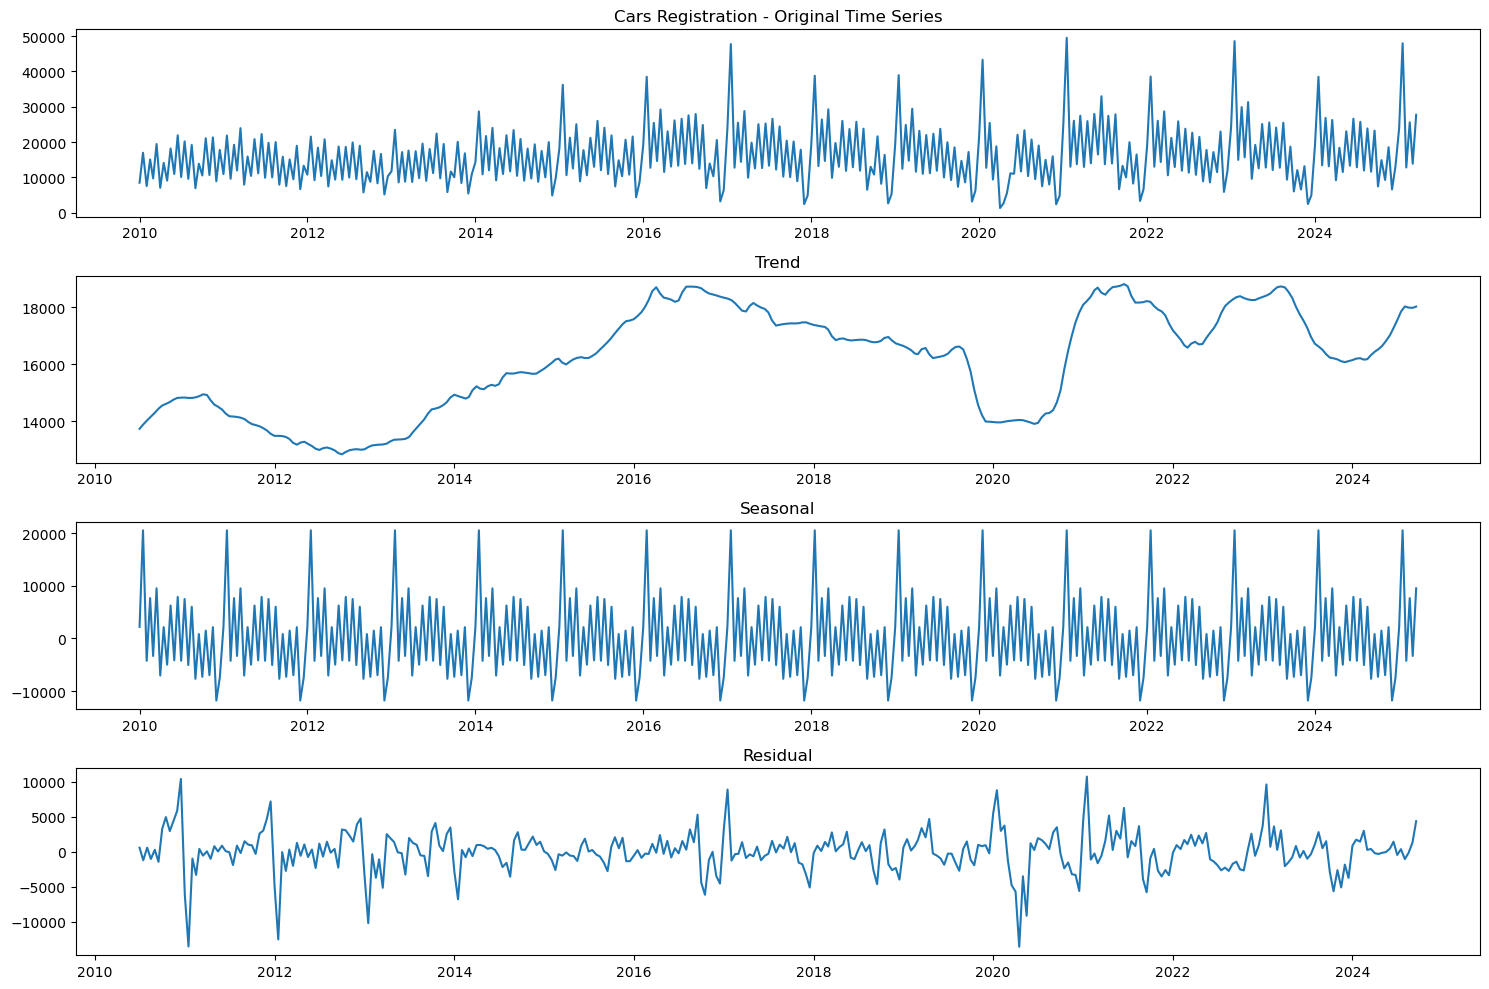

In [43]:
seasonal_analysis(cars_transformed, 24)

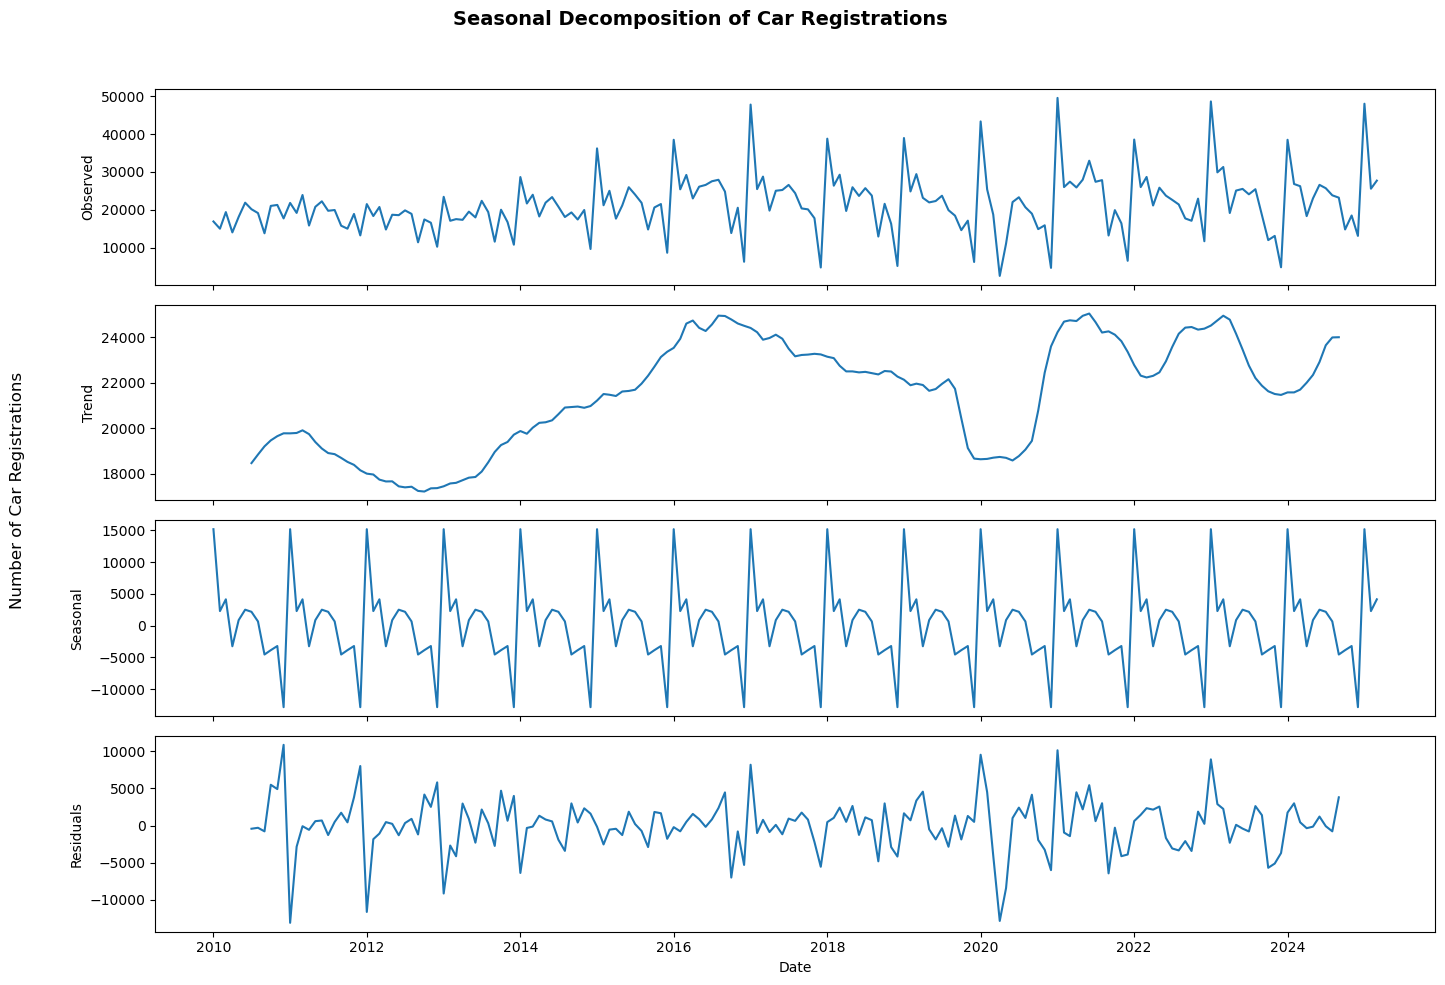

In [85]:
seasonal_analysis(cars_monthly_aggregation, 12)

In [84]:
air = pd.read_csv("data/co_half_monthly.csv")

In [66]:
air_wider = air.pivot(index = 'date', columns='station', values='CO').reset_index()
air_wider['date'] = air_wider['date'].astype('datetime64[ns]')

In [77]:
data_to_submit = pd.merge(air_wider, cars_transformed, on='date')

In [78]:
data_to_submit.to_csv("data/pollution_and_new_cars_unified.csv", index = False)